In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/vscode/anaconda3/envs/odc/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


# Guadalajara

## Download municipalities GeoDataFrame

In [2]:
c = 'Guadalajara'

## Station data

(7, 6)


<AxesSubplot:>

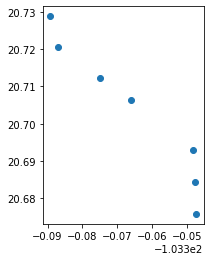

In [3]:
stations_gdf = gpd.read_file('../../data/processed/mass_public_transport/Guadalajara_EstacionesLinea_CambioPob.geojson')
stations_gdf = stations_gdf.to_crs("EPSG:4326")
print(stations_gdf.shape)
stations_gdf.plot()

## Download nodes and edges

In [4]:
buffer_gdf = gpd.GeoDataFrame(stations_gdf.to_crs("EPSG:6372").buffer(5000))
buffer_gdf = buffer_gdf.rename(columns={0:'geometry'}).dissolve()

In [5]:
G, nodes, edges = aup.graph_from_hippo(buffer_gdf, 'osmnx', edges_folder='edges_speed')
edges['time_min'].fillna(edges['time_min'].mean(),inplace=True)

In [6]:
print(nodes.shape)

(40132, 4)


In [7]:
print(edges.shape)

(89141, 19)


## Isocrones

In [8]:
stations_gdf['geometry'] = stations_gdf.geometry.explode(ignore_index=True, index_parts=None)

In [9]:
stations_gdf = aup.find_nearest(G, nodes, stations_gdf)
stations_gdf.head(2)

,Nombre_de_,Sistema,Estructura,Estado,Línea_y_si,geometry,osmid
0,Mercado del Mar,Tren Eléctrico,Elevada,Existente,Línea 3-Tren Ligero,POINT (-103.38925 20.72882),1383965442
1,Zapopan Centro,Tren Eléctrico,Elevada,Existente,Línea 3-Tren Ligero,POINT (-103.38699 20.72058),8740482773


<AxesSubplot:>

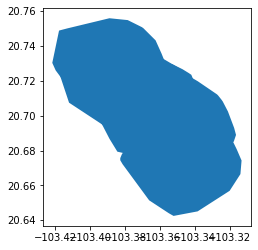

In [10]:
isochrones_gdf = gpd.GeoDataFrame(columns=['metropolis','time_min','geometry'])
time_analysis = [10,20,30,60]

for time in time_analysis:
    for osmid in stations_gdf.osmid.unique():
        geom = aup.calculate_isochrone(G, osmid, time, dist_column='time_min')
        data_dict = {'metropolis':c,
                'time_min':time,
                'geometry':geom}
        df_tmp = pd.DataFrame.from_dict(data_dict, orient='index').T
        isochrones_gdf = pd.concat([isochrones_gdf, df_tmp])

isochrones_gdf.plot()

In [11]:
print(isochrones_gdf.shape)
isochrones_gdf.head(5)

(28, 3)


,metropolis,time_min,geometry
0,Guadalajara,10,"POLYGON ((-103.38885 20.72432, -103.39103 20.7..."
0,Guadalajara,10,"POLYGON ((-103.38376 20.71771, -103.38830 20.7..."
0,Guadalajara,10,"POLYGON ((-103.37812 20.71177, -103.37828 20.7..."
0,Guadalajara,10,"POLYGON ((-103.36171 20.70273, -103.36579 20.7..."
0,Guadalajara,10,"POLYGON ((-103.34812 20.68811, -103.35122 20.6..."


## Download sociodemographic

In [12]:
isochrones_gdf_diss = isochrones_gdf.loc[isochrones_gdf.time_min==60].copy()
isochrones_gdf_diss = isochrones_gdf_diss.dissolve()
isochrones_gdf_diss

,geometry,metropolis,time_min
0,"POLYGON ((-103.35409 20.64362, -103.35488 20.6...",Guadalajara,60


In [13]:
# isochrones_gdf_buffer = isochrones_gdf_diss.to_crs("EPSG:4326")
isochrones_gdf_buffer = isochrones_gdf_diss.copy()
poly_wkt = isochrones_gdf_buffer.geometry.to_wkt()[0]

### Block

#### 2010

In [14]:
folder = 'censo_mza'
table = 'censo_mza_2010'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
mza_10 = aup.gdf_from_query(query, geometry_col='geometry')
mza_10 = mza_10[['CVEGEO','pobtot']].copy()
print(mza_10.shape)
mza_10.head(2)

(7411, 2)


,CVEGEO,pobtot
0,1403900010026001,107
1,1403900010026011,14


#### 2020

In [15]:
folder = 'censo_mza'
table = 'censo_mza_2020'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
mza_20 = aup.gdf_from_query(query, geometry_col='geometry')
mza_20 = mza_20[['CVEGEO','POBTOT','geometry']].copy()
print(mza_20.shape)
mza_20.head(2)

(7640, 3)


,CVEGEO,POBTOT,geometry
0,1403900010030044,2,"POLYGON ((-103.37360 20.71067, -103.37357 20.7..."
1,1403900011607001,5,"POLYGON ((-103.36224 20.67421, -103.36224 20.6..."


#### Comparison

In [16]:
mza_10_20 = mza_20.merge(mza_10, on='CVEGEO', how='left')
print(mza_10_20.shape)
mza_10_20.head(2)

(7640, 4)


,CVEGEO,POBTOT,geometry,pobtot
0,1403900010030044,2,"POLYGON ((-103.37360 20.71067, -103.37357 20.7...",63.0
1,1403900011607001,5,"POLYGON ((-103.36224 20.67421, -103.36224 20.6...",19.0


In [17]:
mza_10_20.loc[mza_10_20['pobtot'].isna(),'pobtot'] = 0
mza_10_20['T_Pob_10_20'] = mza_10_20['POBTOT'] - mza_10_20['pobtot']

<AxesSubplot:>

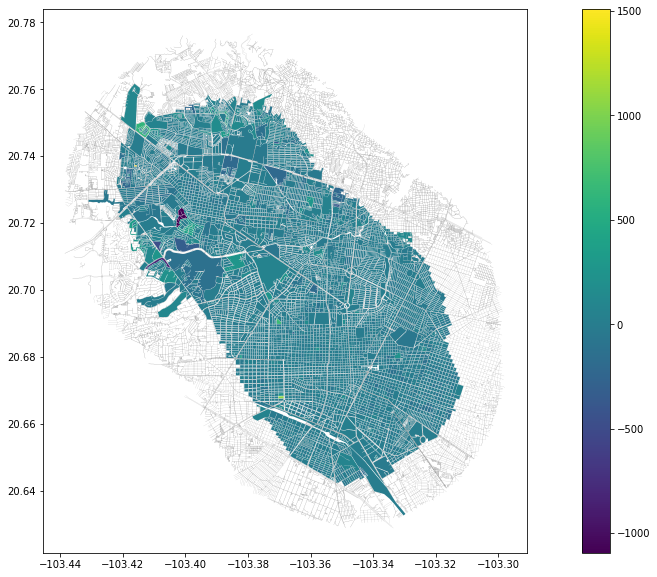

In [18]:
fig, ax = plt.subplots(figsize=(20,10))

mza_10_20.plot('T_Pob_10_20', legend=True, ax=ax)
edges.plot(color='gray',zorder=-1, linewidth=0.1, ax=ax)

### Hex

#### 2010

In [19]:
folder = 'censo'
table = 'hex_censo_mza_2010_res9'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
hex_10 = aup.gdf_from_query(query, geometry_col='geometry')
hex_10 = hex_10[['hex_id_9','pobtot']].copy()
hex_10.rename(columns={'pobtot':'pobtot_2010'}, inplace=True)
print(hex_10.shape)
hex_10.head(2)

(696, 2)


,hex_id_9,pobtot_2010
0,89498c96323ffff,594.0
1,89498c96847ffff,1887.0


#### 2020

In [20]:
folder = 'censo'
table = 'hex_censo_mza_2020_res9'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
hex_20 = aup.gdf_from_query(query, geometry_col='geometry')
hex_20 = hex_20[['hex_id_9','pobtot','geometry']].copy()
print(hex_20.shape)
hex_20.head(2)

(698, 3)


,hex_id_9,pobtot,geometry
0,89498c96323ffff,565.0,"POLYGON ((-103.34076 20.65980, -103.33954 20.6..."
1,89498c96847ffff,1583.0,"POLYGON ((-103.37021 20.68284, -103.36899 20.6..."


#### Comparison

In [21]:
hex_10_20 = hex_20.merge(hex_10, on='hex_id_9', how='left')
print(hex_10_20.shape)
hex_10_20.head(2)

(698, 4)


,hex_id_9,pobtot,geometry,pobtot_2010
0,89498c96323ffff,565.0,"POLYGON ((-103.34076 20.65980, -103.33954 20.6...",594.0
1,89498c96847ffff,1583.0,"POLYGON ((-103.37021 20.68284, -103.36899 20.6...",1887.0


In [22]:
hex_10_20.loc[hex_10_20['pobtot_2010'].isna(),'pobtot_2010'] = 0
hex_10_20['T_Pob_10_20'] = hex_10_20['pobtot'] - hex_10_20['pobtot_2010']

<AxesSubplot:>

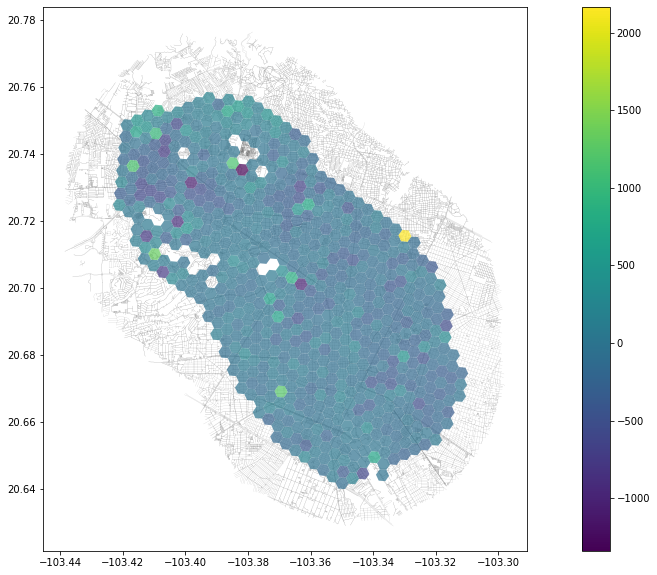

In [23]:
fig, ax = plt.subplots(figsize=(20,10))

hex_10_20.plot('T_Pob_10_20', legend=True, ax=ax, alpha=0.7)
edges.plot(color='gray',zorder=-1, linewidth=0.1, ax=ax)

## Save data

In [24]:
isochrones_gdf_diss = isochrones_gdf.dissolve(by='time_min')

In [25]:
grl_dir = '/workspaces/accesibilidad-urbana/data/processed/pop_change/'
hex_10_20.to_file(grl_dir+f'{c}_Hex_PopChange_Analysis.geojson', driver='GeoJSON')
mza_10_20.to_file(grl_dir+f'{c}_Mza_PopChange_Analysis.geojson', driver='GeoJSON')
isochrones_gdf_diss.to_file(grl_dir+f'{c}_StationIsochrones.geojson', driver='GeoJSON')

# Monterrey

In [26]:
c = 'Monterrey'

## Station data

(9, 4)


<AxesSubplot:>

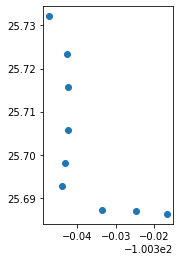

In [27]:
stations_gdf = gpd.read_file(f'../../data/processed/mass_public_transport/{c}_EstacionesLinea_CambioPob.geojson')
stations_gdf = stations_gdf.to_crs("EPSG:4326")
print(stations_gdf.shape)
stations_gdf.plot()

## Download nodes and edges

In [28]:
buffer_gdf = gpd.GeoDataFrame(stations_gdf.to_crs("EPSG:6372").buffer(5000))
buffer_gdf = buffer_gdf.rename(columns={0:'geometry'}).dissolve()

In [29]:
G, nodes, edges = aup.graph_from_hippo(buffer_gdf, 'osmnx', edges_folder='edges_speed')
edges['time_min'].fillna(edges['time_min'].mean(),inplace=True)

In [30]:
print(nodes.shape)

(34720, 4)


In [31]:
print(edges.shape)

(86415, 19)


## Isocrones

In [32]:
stations_gdf['geometry'] = stations_gdf.geometry.explode(ignore_index=True, index_parts=None)

In [33]:
stations_gdf = aup.find_nearest(G, nodes, stations_gdf)
stations_gdf.head(2)

,id,nombre,tipo,geometry,osmid
0,4.0,Aztlán,Metro Linea 1,POINT (-100.34719 25.73213),7468479569
1,5.0,Penitenciaría,Metro Linea 1,POINT (-100.34243 25.72346),7454513845


<AxesSubplot:>

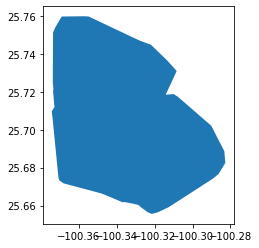

In [34]:
isochrones_gdf = gpd.GeoDataFrame(columns=['metropolis','time_min','geometry'])
time_analysis = [10,20,30,60]

for time in time_analysis:
    for osmid in stations_gdf.osmid.unique():
        geom = aup.calculate_isochrone(G, osmid, time, dist_column='time_min')
        data_dict = {'metropolis':c,
                'time_min':time,
                'geometry':geom}
        df_tmp = pd.DataFrame.from_dict(data_dict, orient='index').T
        isochrones_gdf = pd.concat([isochrones_gdf, df_tmp])

isochrones_gdf.plot()

In [35]:
print(isochrones_gdf.shape)
isochrones_gdf.head(5)

(36, 3)


,metropolis,time_min,geometry
0,Monterrey,10,"POLYGON ((-100.34725 25.72934, -100.34961 25.7..."
0,Monterrey,10,"POLYGON ((-100.34243 25.71933, -100.34462 25.7..."
0,Monterrey,10,"POLYGON ((-100.34250 25.70971, -100.34514 25.7..."
0,Monterrey,10,"POLYGON ((-100.33854 25.70286, -100.34018 25.7..."
0,Monterrey,10,"POLYGON ((-100.34389 25.69300, -100.34477 25.6..."


## Download sociodemographic

In [36]:
isochrones_gdf_diss = isochrones_gdf.loc[isochrones_gdf.time_min==60].copy()
isochrones_gdf_diss = isochrones_gdf_diss.dissolve()
isochrones_gdf_diss

,geometry,metropolis,time_min
0,"POLYGON ((-100.32869 25.66036, -100.33541 25.6...",Monterrey,60


In [37]:
# isochrones_gdf_buffer = isochrones_gdf_diss.to_crs("EPSG:4326")
isochrones_gdf_buffer = isochrones_gdf_diss.copy()
poly_wkt = isochrones_gdf_buffer.geometry.to_wkt()[0]

### Block

#### 2010

In [38]:
folder = 'censo_mza'
table = 'censo_mza_2010'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
mza_10 = aup.gdf_from_query(query, geometry_col='geometry')
mza_10 = mza_10[['CVEGEO','pobtot']].copy()
print(mza_10.shape)
mza_10.head(2)

(6313, 2)


,CVEGEO,pobtot
0,1903900011309010,0
1,1901900010079046,697


#### 2020

In [39]:
folder = 'censo_mza'
table = 'censo_mza_2020'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
mza_20 = aup.gdf_from_query(query, geometry_col='geometry')
mza_20 = mza_20[['CVEGEO','POBTOT','geometry']].copy()
print(mza_20.shape)
mza_20.head(2)

(6390, 3)


,CVEGEO,POBTOT,geometry
0,1903900011563021,5,"POLYGON ((-100.30188 25.68278, -100.30272 25.6..."
1,1903900011205024,6,"POLYGON ((-100.32472 25.68613, -100.32483 25.6..."


#### Comparison

In [40]:
mza_10_20 = mza_20.merge(mza_10, on='CVEGEO', how='left')
print(mza_10_20.shape)
mza_10_20.head(2)

(6390, 4)


,CVEGEO,POBTOT,geometry,pobtot
0,1903900011563021,5,"POLYGON ((-100.30188 25.68278, -100.30272 25.6...",10.0
1,1903900011205024,6,"POLYGON ((-100.32472 25.68613, -100.32483 25.6...",0.0


In [41]:
mza_10_20.loc[mza_10_20['pobtot'].isna(),'pobtot'] = 0
mza_10_20['T_Pob_10_20'] = mza_10_20['POBTOT'] - mza_10_20['pobtot']

<AxesSubplot:>

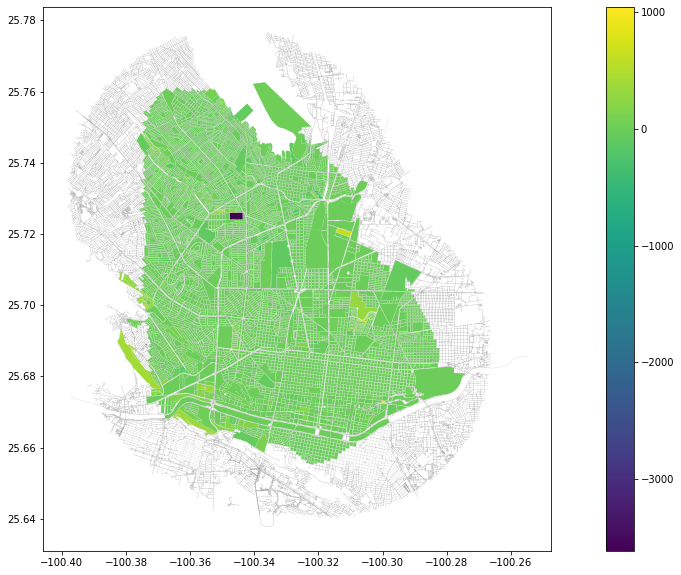

In [42]:
fig, ax = plt.subplots(figsize=(20,10))

mza_10_20.plot('T_Pob_10_20', legend=True, ax=ax)
edges.plot(color='gray',zorder=-1, linewidth=0.1, ax=ax)

### Hex

#### 2010

In [43]:
folder = 'censo'
table = 'hex_censo_mza_2010_res9'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
hex_10 = aup.gdf_from_query(query, geometry_col='geometry')
hex_10 = hex_10[['hex_id_9','pobtot']].copy()
hex_10.rename(columns={'pobtot':'pobtot_2010'}, inplace=True)
print(hex_10.shape)
hex_10.head(2)

(610, 2)


,hex_id_9,pobtot_2010
0,8948a204007ffff,1583.0
1,8948a204633ffff,1099.0


#### 2020

In [44]:
folder = 'censo'
table = 'hex_censo_mza_2020_res9'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
hex_20 = aup.gdf_from_query(query, geometry_col='geometry')
hex_20 = hex_20[['hex_id_9','pobtot','geometry']].copy()
print(hex_20.shape)
hex_20.head(2)

(617, 3)


,hex_id_9,pobtot,geometry
0,8948a204007ffff,1374.0,"POLYGON ((-100.36944 25.72263, -100.36815 25.7..."
1,8948a204633ffff,966.0,"POLYGON ((-100.35131 25.71037, -100.35001 25.7..."


#### Comparison

In [45]:
hex_10_20 = hex_20.merge(hex_10, on='hex_id_9', how='left')
print(hex_10_20.shape)
hex_10_20.head(2)

(617, 4)


,hex_id_9,pobtot,geometry,pobtot_2010
0,8948a204007ffff,1374.0,"POLYGON ((-100.36944 25.72263, -100.36815 25.7...",1583.0
1,8948a204633ffff,966.0,"POLYGON ((-100.35131 25.71037, -100.35001 25.7...",1099.0


In [46]:
hex_10_20.loc[hex_10_20['pobtot_2010'].isna(),'pobtot_2010'] = 0
hex_10_20['T_Pob_10_20'] = hex_10_20['pobtot'] - hex_10_20['pobtot_2010']

<AxesSubplot:>

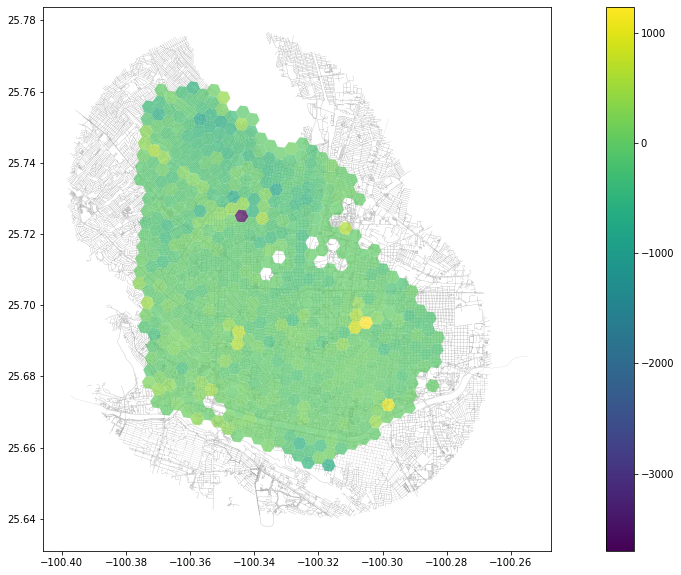

In [47]:
fig, ax = plt.subplots(figsize=(20,10))

hex_10_20.plot('T_Pob_10_20', legend=True, ax=ax, alpha=0.7)
edges.plot(color='gray',zorder=-1, linewidth=0.1, ax=ax)

## Save data

In [48]:
isochrones_gdf_diss = isochrones_gdf.dissolve(by='time_min')

In [49]:
grl_dir = '/workspaces/accesibilidad-urbana/data/processed/pop_change/'
hex_10_20.to_file(grl_dir+f'{c}_Hex_PopChange_Analysis.geojson', driver='GeoJSON')
mza_10_20.to_file(grl_dir+f'{c}_Mza_PopChange_Analysis.geojson', driver='GeoJSON')
isochrones_gdf_diss.to_file(grl_dir+f'{c}_StationIsochrones.geojson', driver='GeoJSON')

# ZMVM

In [50]:
c = 'ZMVM'

## Station data

(10, 16)


<AxesSubplot:>

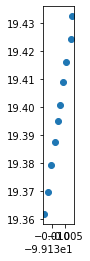

In [51]:
stations_gdf = gpd.read_file(f'../../data/processed/mass_public_transport/{c}_EstacionesLinea_CambioPob.geojson')
stations_gdf = stations_gdf.to_crs("EPSG:4326")
print(stations_gdf.shape)
stations_gdf.plot()

## Download nodes and edges

In [52]:
buffer_gdf = gpd.GeoDataFrame(stations_gdf.to_crs("EPSG:6372").buffer(5000))
buffer_gdf = buffer_gdf.rename(columns={0:'geometry'}).dissolve()

In [53]:
G, nodes, edges = aup.graph_from_hippo(buffer_gdf, 'osmnx', edges_folder='edges_speed')
edges['time_min'].fillna(edges['time_min'].mean(),inplace=True)

In [54]:
print(nodes.shape)

(43907, 4)


In [55]:
print(edges.shape)

(100279, 19)


## Isocrones

In [56]:
stations_gdf['geometry'] = stations_gdf.geometry.explode(ignore_index=True, index_parts=None)

In [57]:
stations_gdf = aup.find_nearest(G, nodes, stations_gdf)
stations_gdf.head(2)

,SISTEMA,NOMBRE,LINEA,EST,CVE_EST,CVE_EOD17,TIPO,ALCALDIAS,AÑO,Elevadores,Guia_tact,P_braile,Ramp_s_rue,layer,path,geometry,osmid
0,STC Metro,Zócalo/Tenochtitlan,02,13,STC0213,05064,Intermedia,Cuauhtémoc,1970,None,None,None,None,STC_Metro_estaciones_utm14n,/home/edgaregurrola/Downloads/transporte_masiv...,POINT Z (-99.13225 19.43250 0.00000),4364089072
1,STC Metro,Pino Suárez,02,14,STC0214,05053,Transbordo,Cuauhtémoc,1970,None,None,None,None,STC_Metro_estaciones_utm14n,/home/edgaregurrola/Downloads/transporte_masiv...,POINT Z (-99.13294 19.42438 0.00000),2353188067


<AxesSubplot:>

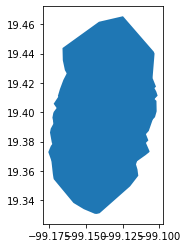

In [58]:
isochrones_gdf = gpd.GeoDataFrame(columns=['metropolis','time_min','geometry'])
time_analysis = [10,20,30,60]

for time in time_analysis:
    for osmid in stations_gdf.osmid.unique():
        geom = aup.calculate_isochrone(G, osmid, time, dist_column='time_min')
        data_dict = {'metropolis':c,
                'time_min':time,
                'geometry':geom}
        df_tmp = pd.DataFrame.from_dict(data_dict, orient='index').T
        isochrones_gdf = pd.concat([isochrones_gdf, df_tmp])

isochrones_gdf.plot()

In [59]:
print(isochrones_gdf.shape)
isochrones_gdf.head(5)

(40, 3)


,metropolis,time_min,geometry
0,ZMVM,10,"POLYGON ((-99.13462 19.43023, -99.13644 19.432..."
0,ZMVM,10,"POLYGON ((-99.13423 19.41871, -99.13578 19.426..."
0,ZMVM,10,"POLYGON ((-99.13554 19.41029, -99.13703 19.412..."
0,ZMVM,10,"POLYGON ((-99.13661 19.40409, -99.13805 19.404..."
0,ZMVM,10,"POLYGON ((-99.13787 19.39547, -99.13919 19.397..."


## Download sociodemographic

In [60]:
isochrones_gdf_diss = isochrones_gdf.loc[isochrones_gdf.time_min==60].copy()
isochrones_gdf_diss = isochrones_gdf_diss.dissolve()
isochrones_gdf_diss

,geometry,metropolis,time_min
0,"POLYGON ((-99.15846 19.33821, -99.17191 19.354...",ZMVM,60


In [61]:
# isochrones_gdf_buffer = isochrones_gdf_diss.to_crs("EPSG:4326")
isochrones_gdf_buffer = isochrones_gdf_diss.copy()
poly_wkt = isochrones_gdf_buffer.geometry.to_wkt()[0]

### Block

#### 2010

In [62]:
folder = 'censo_mza'
table = 'censo_mza_2010'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
mza_10 = aup.gdf_from_query(query, geometry_col='geometry')
mza_10 = mza_10[['CVEGEO','pobtot']].copy()
print(mza_10.shape)
mza_10.head(2)

(8111, 2)


,CVEGEO,pobtot
0,090140001044A015,118
1,0900300010291020,0


#### 2020

In [63]:
folder = 'censo_mza'
table = 'censo_mza_2020'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
mza_20 = aup.gdf_from_query(query, geometry_col='geometry')
mza_20 = mza_20[['CVEGEO','POBTOT','geometry']].copy()
print(mza_20.shape)
mza_20.head(2)

(8578, 3)


,CVEGEO,POBTOT,geometry
0,0900600010787029,19,"POLYGON ((-99.11915 19.39004, -99.11952 19.390..."
1,0900600010378013,0,"POLYGON ((-99.12927 19.39544, -99.12929 19.395..."


#### Comparison

In [64]:
mza_10_20 = mza_20.merge(mza_10, on='CVEGEO', how='left')
print(mza_10_20.shape)
mza_10_20.head(2)

(8578, 4)


,CVEGEO,POBTOT,geometry,pobtot
0,0900600010787029,19,"POLYGON ((-99.11915 19.39004, -99.11952 19.390...",8.0
1,0900600010378013,0,"POLYGON ((-99.12927 19.39544, -99.12929 19.395...",0.0


In [65]:
mza_10_20.loc[mza_10_20['pobtot'].isna(),'pobtot'] = 0
mza_10_20['T_Pob_10_20'] = mza_10_20['POBTOT'] - mza_10_20['pobtot']

<AxesSubplot:>

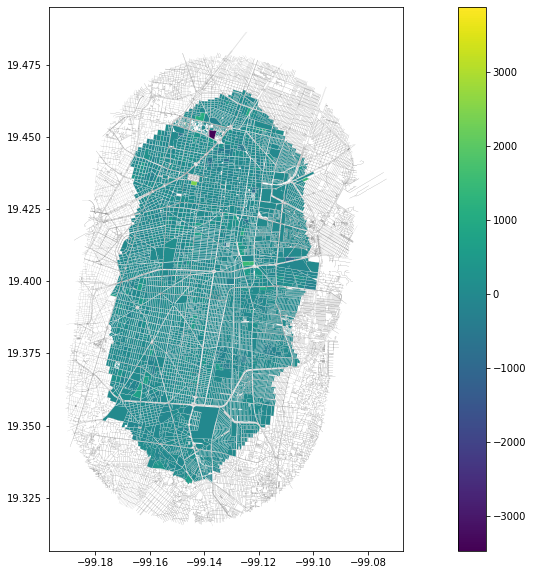

In [66]:
fig, ax = plt.subplots(figsize=(20,10))

mza_10_20.plot('T_Pob_10_20', legend=True, ax=ax)
edges.plot(color='gray',zorder=-1, linewidth=0.1, ax=ax)

### Hex

#### 2010

In [67]:
folder = 'censo'
table = 'hex_censo_mza_2010_res9'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
hex_10 = aup.gdf_from_query(query, geometry_col='geometry')
hex_10 = hex_10[['hex_id_9','pobtot']].copy()
hex_10.rename(columns={'pobtot':'pobtot_2010'}, inplace=True)
print(hex_10.shape)
hex_10.head(2)

(754, 2)


,hex_id_9,pobtot_2010
0,894995859d7ffff,183.0
1,89499585dcbffff,2408.0


#### 2020

In [68]:
folder = 'censo'
table = 'hex_censo_mza_2020_res9'
query = f"SELECT * FROM {folder}.{table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
hex_20 = aup.gdf_from_query(query, geometry_col='geometry')
hex_20 = hex_20[['hex_id_9','pobtot','geometry']].copy()
print(hex_20.shape)
hex_20.head(2)

(754, 3)


,hex_id_9,pobtot,geometry
0,894995859d7ffff,178.0,"POLYGON ((-99.15206 19.35201, -99.15082 19.353..."
1,89499585dcbffff,2591.0,"POLYGON ((-99.14858 19.33121, -99.14734 19.332..."


#### Comparison

In [69]:
hex_10_20 = hex_20.merge(hex_10, on='hex_id_9', how='left')
print(hex_10_20.shape)
hex_10_20.head(2)

(754, 4)


,hex_id_9,pobtot,geometry,pobtot_2010
0,894995859d7ffff,178.0,"POLYGON ((-99.15206 19.35201, -99.15082 19.353...",183.0
1,89499585dcbffff,2591.0,"POLYGON ((-99.14858 19.33121, -99.14734 19.332...",2408.0


In [70]:
hex_10_20.loc[hex_10_20['pobtot_2010'].isna(),'pobtot_2010'] = 0
hex_10_20['T_Pob_10_20'] = hex_10_20['pobtot'] - hex_10_20['pobtot_2010']

<AxesSubplot:>

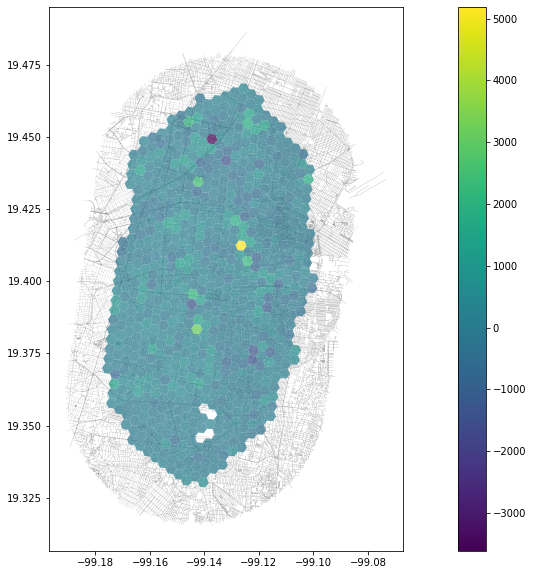

In [71]:
fig, ax = plt.subplots(figsize=(20,10))

hex_10_20.plot('T_Pob_10_20', legend=True, ax=ax, alpha=0.7)
edges.plot(color='gray',zorder=-1, linewidth=0.1, ax=ax)

## Save data

In [72]:
isochrones_gdf_diss = isochrones_gdf.dissolve(by='time_min')

In [73]:
grl_dir = '/workspaces/accesibilidad-urbana/data/processed/pop_change/'
hex_10_20.to_file(grl_dir+f'{c}_Hex_PopChange_Analysis.geojson', driver='GeoJSON')
mza_10_20.to_file(grl_dir+f'{c}_Mza_PopChange_Analysis.geojson', driver='GeoJSON')
isochrones_gdf_diss.to_file(grl_dir+f'{c}_StationIsochrones.geojson', driver='GeoJSON')